# Understanding Semi-Supervised Learning Algorithms

## Technical requirements

We will use the following as technical requirements to run the code in this chapter:
- Python 3.9 or above
- pip
- Tensorflow (with CUDA if you want to train models on GPUs)
    - Keras is installed as a dependency to this
- scikit-learn Python library
    - Numpy is installed as a dependency to this
- Matplotlib library
- Hugging Face's transformers library
- Langchain library
- Jupyter notebook if running the code directly from Jupyter

In [1]:
! python3 -m pip install --upgrade pip

### For M1+ Macbook (64-bit ARM Based processor)

In [2]:
! arch -arm64 pip3 install --upgrade pip
! arch -arm64 pip3 install tensorflow
! arch -arm64 pip3 install -U scikit-learn
! arch -arm64 pip3 install matplotlib

  Using cached tensorflow-2.16.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.3-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.6 kB)
  Using cached grp

### For Other Computer Systems

In [3]:
! pip3 install --upgrade pip
! pip3 install tensorflow
! pip3 install -U scikit-learn
! pip3 install matplotlib

## 5. Hands-on Fine Tuning in Python

### 5.1 Training pre-trained model
First we import the required libraries.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

Then we load and prepare the data.

In [4]:
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    # One-hot encode the labels
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

We then create a function to rotate images and prepare labels.

In [5]:
def create_rotated_images(images):
    angles = [0, 90, 180, 270]
    angle_labels = np.random.randint(0, 3, size=len(images))
    rotated_images = np.array([
        tf.image.rot90(images[i], k=angle_labels[i]).numpy()
        for i in range(len(images))
    ])
    return rotated_images, angle_labels

x_train_rotated, y_train_rotated = create_rotated_images(x_train)
x_test_rotated, y_test_rotated = create_rotated_images(x_test)

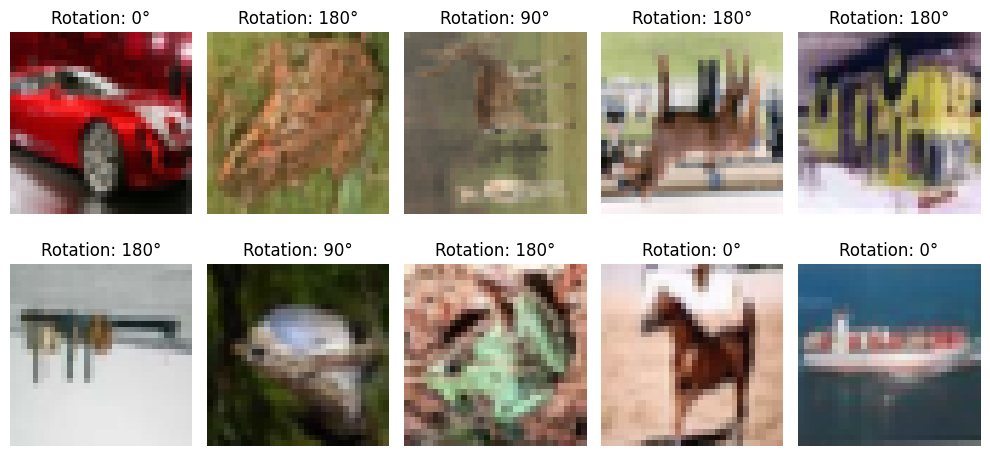

In [6]:
def plot_rotated_images(images, labels):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        idx = np.random.randint(0, images.shape[0])
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx])
        plt.title(f'Rotation: {labels[idx]*90}°')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_rotated_images(x_train_rotated, y_train_rotated)

For the ML model, we'll use a simple CNN model that outputs four classes corresponding to the four rotation angles.

In [7]:
def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

pretext_model = build_model(x_train_rotated[0].shape)

Then we train the model as follows.

In [8]:
pretext_model.fit(x_train_rotated, y_train_rotated, epochs=10, batch_size=64,
                    validation_data=(x_test_rotated, y_test_rotated))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - accuracy: 0.5888 - loss: 0.8666 - val_accuracy: 0.6575 - val_loss: 0.7568
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.7185 - loss: 0.6422 - val_accuracy: 0.7174 - val_loss: 0.6649
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.7661 - loss: 0.5503 - val_accuracy: 0.7172 - val_loss: 0.6596
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.8034 - loss: 0.4787 - val_accuracy: 0.7668 - val_loss: 0.5534
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.8288 - loss: 0.4213 - val_accuracy: 0.7943 - val_loss: 0.5034
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.8466 - loss: 0.3758 - val_accuracy: 0.7470 - val_loss: 0.6430
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.8712 - loss: 0.3272 - val_accuracy: 0.7580 - val_loss: 0.6467
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.8857 - loss: 0.2874 - 

### 5.2 Fine tuning classification model

Now that we have a pre-trained model, we can discard some of the last few dense layers and retain the first few layers to use them in a model that would predict the label of the dataset. We will freeze the layers from the pre-trained models so that they are not retrained when we fit the transfer model. For comparison, we will also train another model from scratch and see the accuracy of the results.

In [9]:
def build_transfer_model(base_model, input_shape, num_classes):
    # Remove the last 2 dense layers and flatten layer
    base_model = models.Model(inputs=base_model.input,
                              outputs=base_model.get_layer(index=-5).output)
    
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the convolutional layers

    new_model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

transfer_model = build_transfer_model(pretext_model, x_train[0].shape, 10)

Next we fine tune the transfer model for classification on the original data with class labels.

In [10]:
transfer_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.5190 - loss: 1.4199 - val_accuracy: 0.6029 - val_loss: 1.1374
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6479 - loss: 0.9768 - val_accuracy: 0.6112 - val_loss: 1.1031
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7075 - loss: 0.8190 - val_accuracy: 0.6105 - val_loss: 1.1522
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7585 - loss: 0.6779 - val_accuracy: 0.6143 - val_loss: 1.1845
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8057 - loss: 0.5465 - val_accuracy: 0.6102 - val_loss: 1.3013
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8556 - loss: 0.4176 - val_accuracy: 0.6061 - val_loss: 1.4735
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8933 - loss: 0.3128 - val_accuracy: 0.5941 - val_loss: 1.6439
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9153 -

In [11]:
loss, accuracy = transfer_model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5940 - loss: 2.2164
Test accuracy: 58.94%


### 5.3 Training classification model from scratch

Let's train a classification model from scratch for comparison.

In [12]:
def build_scratch_model(image, num_classes):
    scratch_model = build_model(image.shape)
    
    scratch_model = models.Model(inputs=scratch_model.input,
                                  outputs=scratch_model.get_layer(index=-2).output)
    
    scratch_model = models.Sequential([
            scratch_model,
            layers.Dense(num_classes, activation='softmax')
        ])
    
    scratch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return scratch_model

scratch_model = build_scratch_model(x_train[0], 10)

In [13]:
scratch_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.4815 - loss: 1.4120 - val_accuracy: 0.5222 - val_loss: 1.5357
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7188 - loss: 0.7925 - val_accuracy: 0.6783 - val_loss: 0.9390
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7843 - loss: 0.6196 - val_accuracy: 0.6757 - val_loss: 1.0819
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8192 - loss: 0.5150 - val_accuracy: 0.7593 - val_loss: 0.7193
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8521 - loss: 0.4197 - val_accuracy: 0.7849 - val_loss: 0.6553
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8790 - loss: 0.3477 - val_accuracy: 0.7867 - val_loss: 0.6423
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8942 - loss: 0.3016 - val_accuracy: 0.8054 - val_loss: 0.6381
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.9135 -

As you would notice, when we train the model from scratch, it would take a lot more time for model training for each epoch (evident by time per step). We also note that the model accuracy is comparable while we get a massive gains in training time and thereby computational resources. This helps us understand how using pre-trained models can be of great benefit and can be applied to many of the use cases in practice.

### 5.4 Introduction to Hugging Face and LangChain Libraries

#### 5.4.1 Hugging Face _transformers_ Library
To get started, you first need to install the transformers library. It's generally used with a backend like PyTorch or TensorFlow. Here, I'll show an example using PyTorch. We'll also install backwards-compatible tf-keras package used by _transformers_ library.

In [14]:
## For M1+ Macbook (64-bit ARM Based processor)
! arch -arm64 pip3 install transformers torch
! arch -arm64 pip3 install tf-keras

## For Other Computer Systems
# ! pip3 install transformers torch
# ! pip3 install tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.5 MB/s eta 0:00:00
  Using cached torch-2.3.0-cp310-none-macosx_11_0_arm64.whl.metadata (26 kB)
  Using cached filelock-3.14.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached huggingface_hub-0.23.2-py3-none-any.whl.metadata (12 kB)
  Using cached regex-2024.5.15-cp310-cp310-macosx_11_0_arm64.whl.metadata (40 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached safetensors-0.4.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (3.8 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached fsspec-2024.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 8.7 MB/s eta 0:00:0000:0100:01
Using cached torch-2.3.0-cp310-none-macosx_11_0_arm64.whl (61.0 MB)
Using cached huggingface_hub-0.23.2-py3-none-an

One of the simplest uses of the _transformers_ library is to load a pre-trained model and use it for inference. Let's use the BERT model for a sentiment analysis task. We will first import the _pipeline_ module from the _transformers_ library. The _pipeline_ module abstract a lot of details away for us and makes it easy to load a pre-trained model for NLP tasks. Then we use the task _sentiment_analysis_ to automatically select and load a model that is trained on sentiment analysis tasks. There are a lot of other tasks available like _text-generation_ (full list: https://huggingface.co/docs/transformers/en/main_classes/pipelines#transformers.pipeline.task) and we can also specify a specific model to be selected by the _pipeline_. We then apply the classifier model returned by the _pipeline_ to a sentence to determine its sentiment.

In [15]:
import tensorflow.keras as tf_keras
from transformers import pipeline

sentiment_pipeline = pipeline('sentiment-analysis')

text = "I love learning new things about AI and I am excited to read the book on Self-Supervised learning."
result = sentiment_pipeline(text)

print(result)

/Users/rajatgoel/PycharmProjects/Semi-Self-Supervised-Learning-with-Python/ch3_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Users/rajatgoel/PycharmProjects/Semi-Self-Supervised-Learning-with-Python/ch3_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[{'label': 'POSITIVE', 'score': 0.9997403025627136}]


The output is a list of dictionaries, each containing the label (e.g., 'POSITIVE' or 'NEGATIVE') and score (a confidence level between 0 and 1).

Under the hood, the _pipeline_ selects a default model and tokenizer for the specified task and then the sentence provided as an input is first tokenized to convert it to model appropriate input and then fed into the model for predictions or generations. In the following code, we will specify the model and the tokenizer used by the BERT model for English language. We will learn more about the tokenizers and BERT model in Chapter 6.

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

text = "I love learning new things about AI and I am excited to read the book on Self-Supervised learning."
result = sentiment_pipeline(text)

print(result)

[{'label': 'POSITIVE', 'score': 0.9997403025627136}]


As you can notice, the result is exactly the same. So now you know what goes into a pipeline from a transformers library from Hugging Face. The importance of transformers library becomes apparent when they are being used to fine-tune the pre-trained models using neural networks using existing modules from Tensorflow or PyTorch. You can read more on how to fine-tune a pretrained model in Tensorflow with Keras or native PyTorch from the official documentation from Hugging Face: https://huggingface.co/docs/transformers/training

#### 5.4.2 LangChain Library
We need to first install langchain package along with necessary dependencies. Since LangChain can integrate with several backend providers like OpenAI for GPT models, you might also need API keys for those services if you plan to use their models. You can create the OpenAI API account to generate API access key here: https://platform.openai.com/

In [17]:
## For M1+ Macbook (64-bit ARM Based processor)
! arch -arm64 pip3 install langchain langchain-community langchain-core openai

## For Other Computer Systems
# ! pip3 install langchain langchain-community langchain-core openai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached langchain-0.2.1-py3-none-any.whl.metadata (13 kB)
  Using cached langchain_community-0.2.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached SQLAlchemy-2.0.30-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.6 kB)
  Using cached aiohttp-3.9.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.5 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
  Using cached langchain_text_splitters-0.2.0-py3-none-any.whl.metadata (2.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.3 MB/s eta 0:00:00
  Using cached tenacity-8.3.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached dataclasses_json-0.6.6-py3-none-any.whl.metadata (25 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp310-cp310-macosx_11_0_arm64

To demonstrate the basic capabilities of LangChain, let's create a simple application that uses an OpenAI GPT model to answer questions based on a provided text. This example assumes you have an API key for OpenAI. We first import the necessary modules.

In [18]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain, SequentialChain

We set the API key for OpenAI as an environment variable _OPENAI_API_KEY_ which is fetched directly by the _OpenAI_ class instance. The model name is passed to the _OpenAI_ class to initialize the language model.

In [24]:
from getpass import getpass
import os
OPENAI_API_KEY = getpass()
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

 ········


In [25]:
from langchain_community.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo-0125")

_PromptTemplate_ is designed to structure the input to the language model in a way that fits the task. For our example, we want to get the book title from its genre. The template includes placeholders for context and the question.

In [26]:
prompt_template_title = PromptTemplate(
    input_variables=['genre'],
    template="Suggest a book title from the genre {genre}."
)

_LLMChain_ class in LangChain is a type of chain that runs queries against a LLM. Chains in LangChain orchestrate the flow, sending formatted prompts to the language model and processing the outputs.

In [27]:
title_chain = LLMChain(
    llm=llm,
    prompt=prompt_template_title,
    output_key="book_title"
)

The _run()_ method takes the question and context, processes them through the configured chain, and returns the generated answer.

In [28]:
genre = "Romance"
answer = title_chain.run(genre=genre)

print("Answer:", answer)

Answer: "Love's Sweet Surrender"


We can subsequently chain the output from the LLM as an input to another prompt and get the final result as follows.

In [29]:
prompt_template_content = PromptTemplate(
    input_variables=['book_title'],
    template="Generate a sentence for the book titled {book_title}."
)

content_chain = LLMChain(
    llm=llm,
    prompt=prompt_template_content,
    output_key="book_content"
)

chain = SequentialChain(
        chains=[title_chain, content_chain],
        input_variables=['genre'],
        output_variables=['book_title', 'book_content']
    )

content_from_seq_chain = chain({'genre':'Romance'})
print(content_from_seq_chain)

/Users/rajatgoel/PycharmProjects/Semi-Self-Supervised-Learning-with-Python/ch3_env/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


{'genre': 'Romance', 'book_title': '"Love in Bloom"', 'book_content': '"Love in Bloom tells the story of a forbidden romance that blossoms against all odds in the midst of a beautiful garden."'}
